# Customizing LayoutParser Models Using Studio Label Annotation

Steps:
1. Define the problem - what is the extraction target?
2. Create a training dataset - define annotation schema and label
3. Train layout models - set up machines, train/test split
4. Use new layout model - parse outputs based on model

In [43]:
import layoutparser as lp
import pandas as pd
import numpy as np
import glob
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Define the problem

Task definition: given a scanned index card, we would like to extract text fields within segmented blocks as shown below

This is an example of the kind of layout we would like the model to recognize. The fields are:
- name and location of the mortgagee (`Abbey, Leonard Ray and Barbara Joan, Tulsa, Oklahoma`)
- mortgage amount (`$8,000.`)
- mortgage ID number (`LE-6746`)
- agent serial number (`Agent's Serial No. 44`)
- the status of the mortgage (`(VA) FIRST MORTGAGE LOAN GUARANTEED`)
- the mortgage company (`W.R. Johnston & Co., Inc., Oklahoma City, Oklahoma`)

Notes:
- bounding boxes should include as little whitespace as possible ("snap to text")
- in cases where boxes may overlap, it's better to create smaller, discrete boxes instead
- the model may not be able to discriminate nearby text, so it's better to lump and handle in post-processing

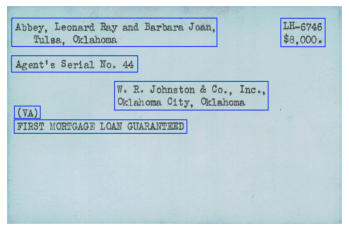

In [46]:
ex_image = cv2.imread('../example-boxes.jpg')
plt.axis('off')
plt.imshow(image, aspect='auto');

Problem: pretrained models are not optimized for this kind of index card layout

Demonstrate bounding box collision on image using [PrimaLayout](https://www.primaresearch.org/dataset/) pretrained model for magazine pages from LayoutParser Model Zoo 

/Users/slafia/miniconda3/envs/layout/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/Users/slafia/miniconda3/envs/layout/lib/python3.6/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/Users/slafia/miniconda3/en

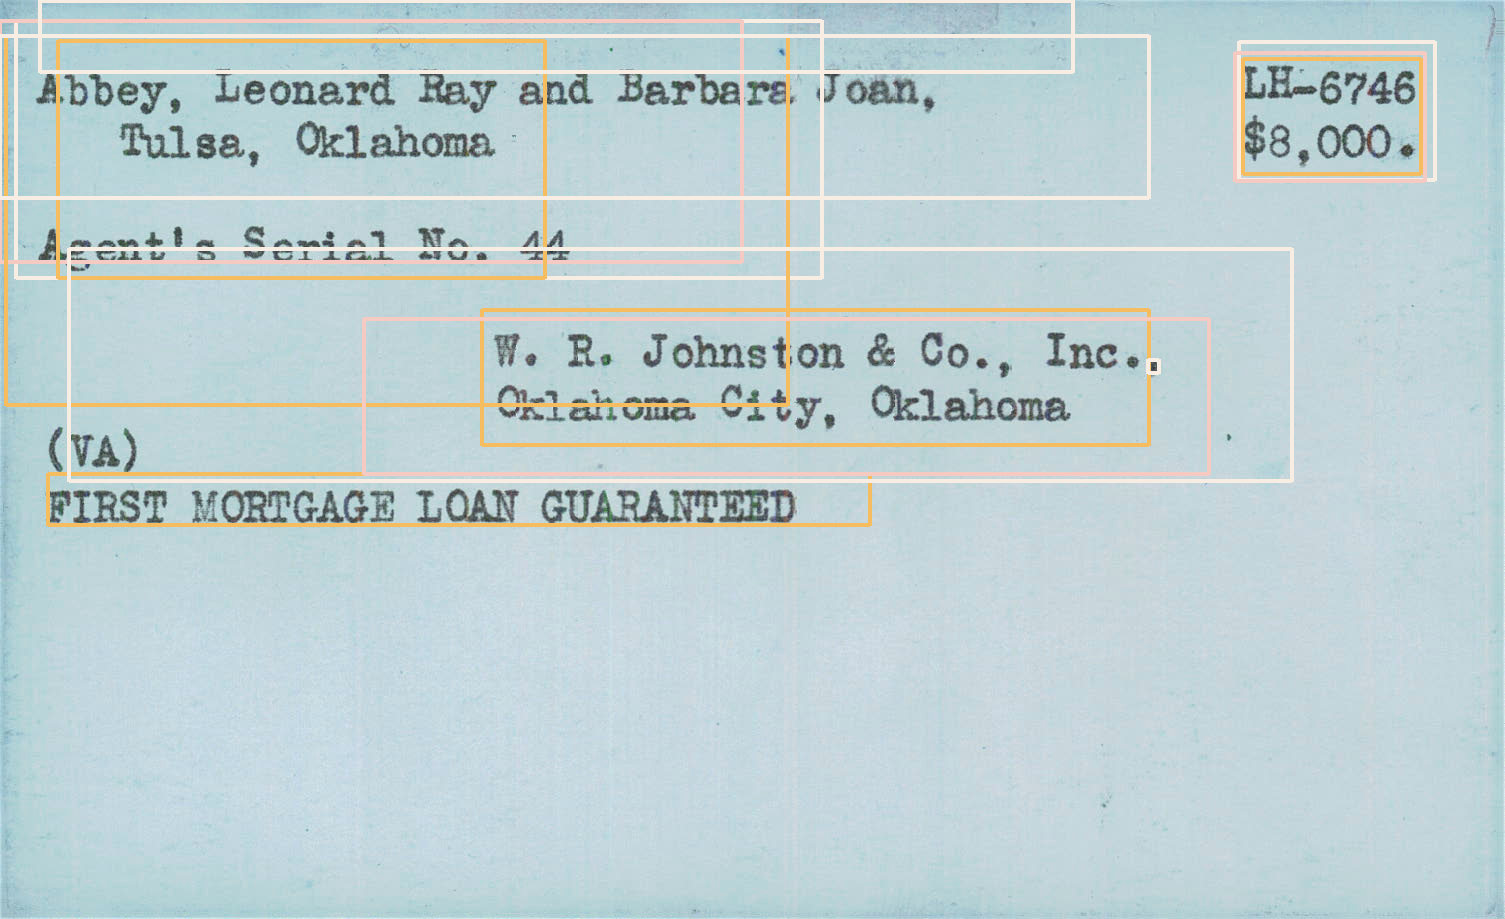

In [42]:
image_file = sorted(glob.glob('../sample_scans/274-01-0003.jpg'))
image = cv2.imread(image_file[0])
model = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config')
layout_result = model.detect(image)
lp.draw_box(image, layout_result)

## 2. Create a training dataset 

Label sample cards in [Label Studio](https://labelstud.io/) (13 cards took 12 mins.)


In [8]:
from pycocotools.coco import COCO
import random

def load_coco_annotations(annotations, coco=None):
    layout = lp.Layout()
    for ele in annotations:
        x, y, w, h = ele['bbox']
        layout.append(
            lp.TextBlock(
                block = lp.Rectangle(x, y, w+x, h+y),
                type = ele['category_id'] if coco is None else coco.cats[ele['category_id']]['name'],
                id = ele['id']
            )
        )
    return layout

In [74]:
COCO_ANNO_PATH = '../downloaded-annotations/result.json'
COCO_IMG_PATH = '../downloaded-annotations/images'

coco = COCO(COCO_ANNO_PATH)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Load data annotated with Label Studio and check that it's rendered correctly

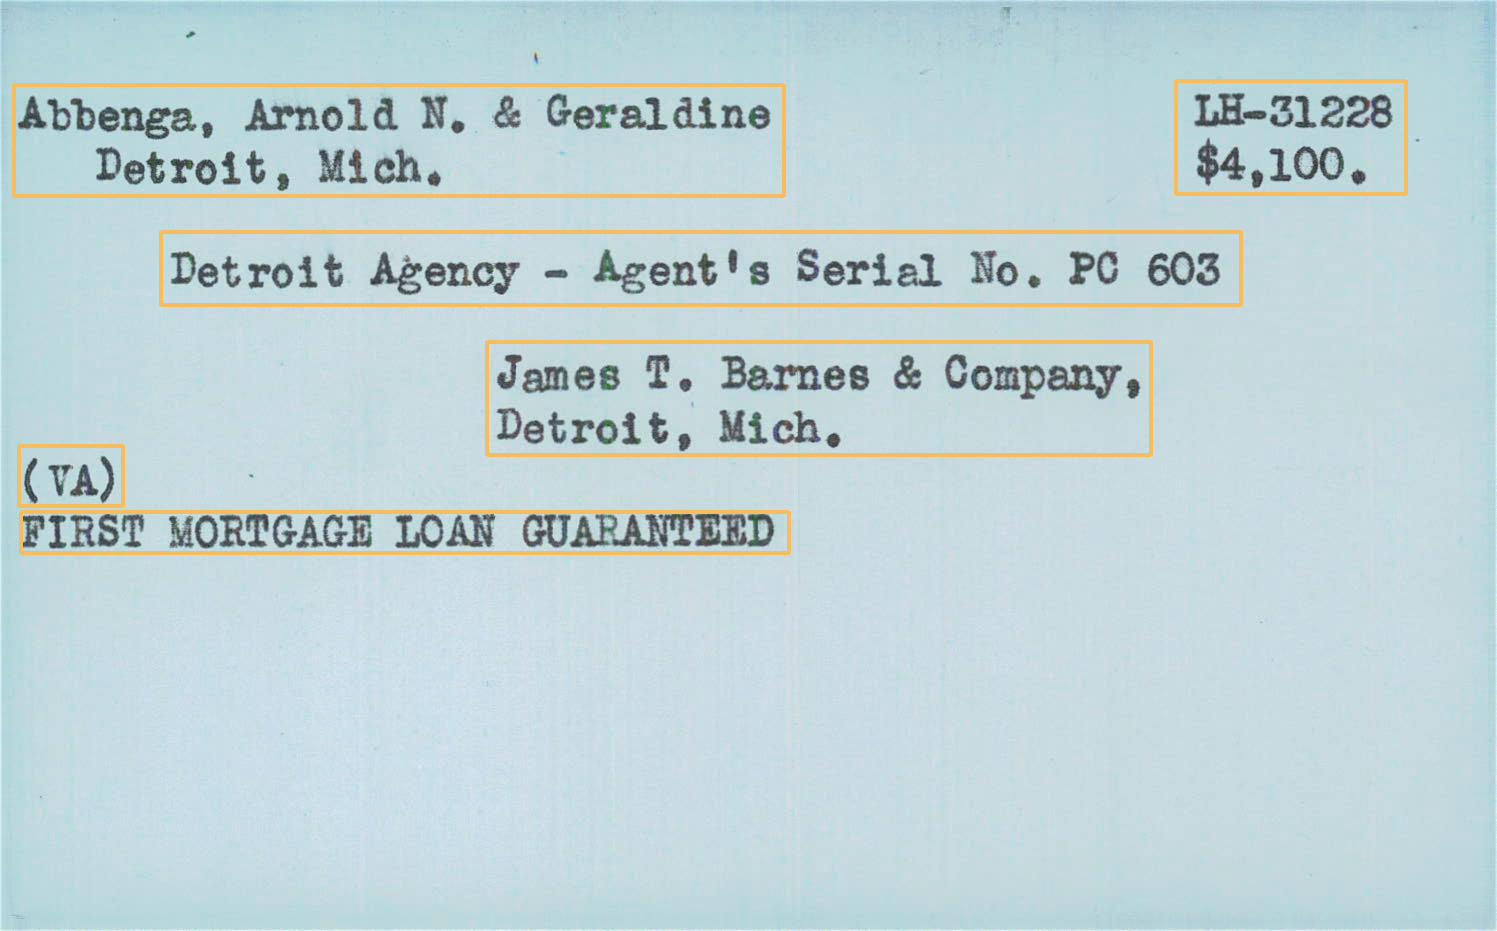

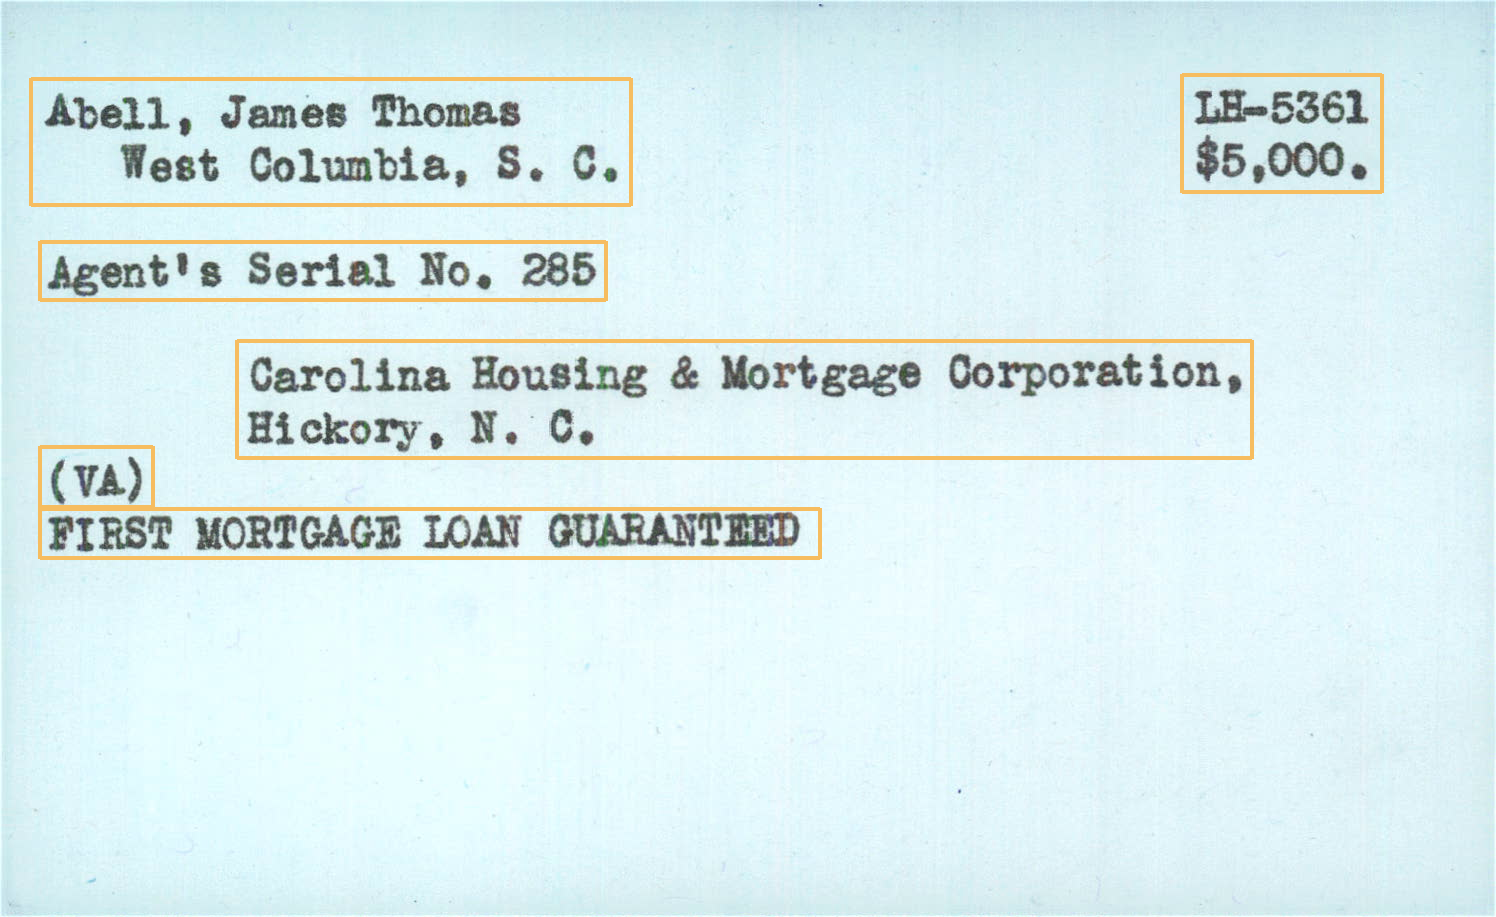

In [76]:
for image_id in random.sample(coco.imgs.keys(), 2):
    image_info = os.path.basename(str(coco.imgs[image_id]['file_name']))
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))
    
    image = cv2.imread(f'{COCO_IMG_PATH}/{image_info}')
    layout = load_coco_annotations(annotations, coco)
    
    viz = lp.draw_box(image, layout)
    display(viz)

## 3. Train layout model
Given a new dataset, produce a new layout model optimized for new dataset (performance will depend on the size and difficulty of the dataset)

Clone this repo (https://github.com/Layout-Parser/layout-model-training)
Train-test split (`python cocosplit.py`)
Run training (modify )

Ideal: GPU machine w/12+ GB of RAM, ~100 examples, model trained in 1.5hrs.